## PROG vs NON-PROG

### Imports

In [1]:
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import RNN as rec
import matplotlib.pyplot as plt
import seaborn as sns
from Utils import Utils
from torchvision import transforms
from FeatureExtractors import AudioFeatureExtractor, SpecAudioFeatureExtractor
from Datasets import SnippetProgDataset
from torch.utils.data import DataLoader
from torchsummary import summary
from songList import load_csv, generate_table
import pandas as pd
from torch.utils.tensorboard import SummaryWriter

### Loading the songs and datasets

In [ ]:
train_songs = load_csv("train_audio_files.csv")
validate_songs = load_csv("validate_audio_files.csv")

In [ ]:
CLASS_NAMES = ['Non-Prog', 'Prog']
SAMPLING_RATE = 11025
SNIPPET_LENGTH = 10

In [ ]:
transform = transforms.Compose([
        AudioFeatureExtractor(sr = SAMPLING_RATE),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.0], std = [1.0])
])

In [ ]:
train_dataset = Utils.getData(SnippetProgDataset, train_songs, transform, True)
validate_dataset = Utils.getData(SnippetProgDataset, validate_songs, transform, False)

In [6]:
print("Train dataset size: ", len(train_dataset))
print("Validate dataset size: ", len(validate_dataset))

Train dataset size:  15345
Validate dataset size:  4127


### Device

In [7]:
writer = None
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
torch.cuda.empty_cache()
print(f"The current device used is {device}")

The current device used is cuda


### Parameters

In [8]:
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 1e-3

In [9]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, num_workers = 2, shuffle = True)
validation_loader = DataLoader(validate_dataset, batch_size = BATCH_SIZE, num_workers = 2, shuffle = True)

### Model Architecture

In [10]:
class ProgCNN(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 1, dropout: float = 0.2):
        super(ProgCNN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv1 = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size = 3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.dropout = nn.Dropout(dropout)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = 3, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2)
        )

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 2 * 4, 512),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        self.fc3 = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU()
        )

        self.fc4 = nn.Sequential(
            nn.Linear(64, self.out_channels),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.sigmoid(self.fc4(x))
        return x

### Training Plan

In [11]:
EXPERIMENT = 5
model = ProgCNN().to(device)
summary(model, (1, 160, 216))
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
writer = Utils.documentModel(writer, NUM_EPOCHS, LEARNING_RATE, SAMPLING_RATE, SNIPPET_LENGTH, BATCH_SIZE, SnippetProgDataset, EXPERIMENT, model, loss_fn, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 79, 107]             640
       BatchNorm2d-2          [-1, 64, 79, 107]             128
              ReLU-3          [-1, 64, 79, 107]               0
           Dropout-4          [-1, 64, 79, 107]               0
            Conv2d-5          [-1, 128, 38, 52]          73,856
       BatchNorm2d-6          [-1, 128, 38, 52]             256
              ReLU-7          [-1, 128, 38, 52]               0
         AvgPool2d-8          [-1, 128, 19, 26]               0
           Dropout-9          [-1, 128, 19, 26]               0
           Conv2d-10          [-1, 256, 17, 24]         295,168
      BatchNorm2d-11          [-1, 256, 17, 24]             512
             ReLU-12          [-1, 256, 17, 24]               0
        AvgPool2d-13           [-1, 256, 8, 12]               0
          Dropout-14           [-1, 256

In [12]:
print(model)

ProgCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), dilation=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, str

### Helper Functions

In [13]:
def updateSongDict(dictionary, metadata, outputs):
    for idx, song_name in enumerate(metadata['song_name']):
        if song_name not in dictionary:
            dictionary[song_name] = []
        dictionary[song_name].append((metadata['snippet_idx'][idx].item(), outputs[idx].item()))

def saveModel(model, name:str, epoch:int, path = "models/"):
    model.eval()
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }, path + name)
    print(f"Model Saved at {epoch}th epoch as {name}")

In [14]:
def train(train_loader, epoch, writer, num_batch_prints = 5, clipping_value = 1):
    model.train()
    correct = 0
    running_loss = 0.0
    batch_print_idx = len(train_loader) // num_batch_prints
    if epoch == 1:
        print(f"Train Epoch: {epoch}")
        
    for batch_idx, (inputs,  labels, metadata) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = inputs.float(), labels.float()
        
        outputs = model(inputs).reshape(-1)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
           
        predictions = (outputs > 0.5).long().reshape(-1)
        correct += (predictions == labels).sum()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
        optimizer.step()
        
        if batch_idx % batch_print_idx == 0:
            print(f"\tTrain Batch: {(batch_idx) + 1} \tBatchwise Loss: {loss.item():.4f}")
            
    running_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    if writer:
        writer.add_scalar("training_avg_loss", running_loss, epoch)
        writer.add_scalar("training_accuracy", accuracy, epoch)
    print(f"Train Epoch: {epoch}\tEpochwise Loss: {running_loss:.4f}\tEpoch Accuracy: [{correct}/{len(train_loader.dataset)}] {accuracy:.2f}%")
    return accuracy.cpu().item(), running_loss

In [15]:
def validate(validation_loader, writer, epoch = NUM_EPOCHS):
    model.eval()
    model.train(False)

    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels, metadata in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = inputs.float(), labels.float()
            
            outputs = model(inputs).reshape(-1)
            test_loss += loss_fn(outputs, labels).item()
            predictions = (outputs > 0.5).long().reshape(-1)
            correct += (predictions == labels).sum()
            
        test_loss /= len(validation_loader)
        accuracy = 100. * correct / len(validation_loader.dataset)
        if writer:
            writer.add_scalar("validation_avg_loss", test_loss, epoch)
            writer.add_scalar("validation_accuracy", accuracy, epoch)
        print(f"Validation Set: Avg Loss: {test_loss:.4f}, Accuracy: {correct}/{len(validation_loader.dataset)} ({accuracy:.2f}%)")
        return accuracy.cpu().item(), test_loss

In [16]:
def evaluate(loader, model, set_name = "Test"):
    model.eval()
    loss = 0.0
    correct = 0
    predictions_dict = {}
    results = {}
    with torch.no_grad():
        for inputs, labels, metadata in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = inputs.float(), labels.float()
            
            outputs = model(inputs).reshape(-1)
            loss += loss_fn(outputs, labels).item()
            predictions = (outputs > 0.5).long().reshape(-1)
            correct += (predictions == labels).sum()
            
            results = Utils.getConfusionMatrix(results, predictions.cpu().detach().numpy(), labels.cpu().detach().numpy())
            updateSongDict(predictions_dict, metadata, outputs)
            
        loss /= len(loader)
        accuracy = 100. * correct / len(loader.dataset)
    print(f"{set_name} Set: Avg Loss: {loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({accuracy:.2f}%)")
    return predictions_dict, results

### Training over snippets

Train Epoch: 1


	Train Batch: 1 	Batchwise Loss: 0.6892


/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


	Train Batch: 97 	Batchwise Loss: 0.6057
	Train Batch: 193 	Batchwise Loss: 0.5256
	Train Batch: 289 	Batchwise Loss: 0.5868
	Train Batch: 385 	Batchwise Loss: 0.5584
Train Epoch: 1	Epochwise Loss: 0.0185	Epoch Accuracy: [10180/15345] 66.34%
Validation Set: Avg Loss: 0.6369, Accuracy: 2377/4127 (57.60%)
Model Saved at 1th epoch as model_exp5.pth
	Train Batch: 1 	Batchwise Loss: 0.5539


/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


	Train Batch: 97 	Batchwise Loss: 0.5703
	Train Batch: 193 	Batchwise Loss: 0.5013
	Train Batch: 289 	Batchwise Loss: 0.4541
	Train Batch: 385 	Batchwise Loss: 0.5141
Train Epoch: 2	Epochwise Loss: 0.0170	Epoch Accuracy: [10997/15345] 71.67%
Validation Set: Avg Loss: 0.5894, Accuracy: 2825/4127 (68.45%)
Model Saved at 2th epoch as model_exp5.pth
	Train Batch: 1 	Batchwise Loss: 0.4789


/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


	Train Batch: 97 	Batchwise Loss: 0.5550
	Train Batch: 193 	Batchwise Loss: 0.5765
	Train Batch: 289 	Batchwise Loss: 0.6575
	Train Batch: 385 	Batchwise Loss: 0.4930
Train Epoch: 3	Epochwise Loss: 0.0159	Epoch Accuracy: [11421/15345] 74.43%
Validation Set: Avg Loss: 0.5729, Accuracy: 2898/4127 (70.22%)
Model Saved at 3th epoch as model_exp5.pth
	Train Batch: 1 	Batchwise Loss: 0.5365


/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


	Train Batch: 97 	Batchwise Loss: 0.5968
	Train Batch: 193 	Batchwise Loss: 0.5959
	Train Batch: 289 	Batchwise Loss: 0.6204
	Train Batch: 385 	Batchwise Loss: 0.3942
Train Epoch: 4	Epochwise Loss: 0.0149	Epoch Accuracy: [11817/15345] 77.01%
Validation Set: Avg Loss: 0.5892, Accuracy: 2716/4127 (65.81%)


/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


	Train Batch: 1 	Batchwise Loss: 0.4062
	Train Batch: 97 	Batchwise Loss: 0.3871
	Train Batch: 193 	Batchwise Loss: 0.4443
	Train Batch: 289 	Batchwise Loss: 0.3598
	Train Batch: 385 	Batchwise Loss: 0.5218
Train Epoch: 5	Epochwise Loss: 0.0141	Epoch Accuracy: [12054/15345] 78.55%
Validation Set: Avg Loss: 0.5297, Accuracy: 3012/4127 (72.98%)
Model Saved at 5th epoch as model_exp5.pth
	Train Batch: 1 	Batchwise Loss: 0.3982


/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


	Train Batch: 97 	Batchwise Loss: 0.5181
	Train Batch: 193 	Batchwise Loss: 0.4340
	Train Batch: 289 	Batchwise Loss: 0.6000
	Train Batch: 385 	Batchwise Loss: 0.5156
Train Epoch: 6	Epochwise Loss: 0.0133	Epoch Accuracy: [12349/15345] 80.48%
Validation Set: Avg Loss: 0.5169, Accuracy: 3086/4127 (74.78%)
Model Saved at 6th epoch as model_exp5.pth


/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


	Train Batch: 1 	Batchwise Loss: 0.3707


/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


	Train Batch: 97 	Batchwise Loss: 0.3081
	Train Batch: 193 	Batchwise Loss: 0.5685
	Train Batch: 289 	Batchwise Loss: 0.3143
	Train Batch: 385 	Batchwise Loss: 0.3562
Train Epoch: 7	Epochwise Loss: 0.0127	Epoch Accuracy: [12501/15345] 81.47%
Validation Set: Avg Loss: 0.8164, Accuracy: 2537/4127 (61.47%)
	Train Batch: 1 	Batchwise Loss: 0.3522


/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


	Train Batch: 97 	Batchwise Loss: 0.3887
	Train Batch: 193 	Batchwise Loss: 0.5124
	Train Batch: 289 	Batchwise Loss: 0.4187
	Train Batch: 385 	Batchwise Loss: 0.3290
Train Epoch: 8	Epochwise Loss: 0.0123	Epoch Accuracy: [12655/15345] 82.47%
Validation Set: Avg Loss: 0.7815, Accuracy: 2576/4127 (62.42%)
	Train Batch: 1 	Batchwise Loss: 0.3866


/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


	Train Batch: 97 	Batchwise Loss: 0.4815
	Train Batch: 193 	Batchwise Loss: 0.3381
	Train Batch: 289 	Batchwise Loss: 0.4335
	Train Batch: 385 	Batchwise Loss: 0.3799
Train Epoch: 9	Epochwise Loss: 0.0119	Epoch Accuracy: [12715/15345] 82.86%
Validation Set: Avg Loss: 0.6501, Accuracy: 2830/4127 (68.57%)
	Train Batch: 1 	Batchwise Loss: 0.2826


/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


	Train Batch: 97 	Batchwise Loss: 0.2538
	Train Batch: 193 	Batchwise Loss: 0.3372
	Train Batch: 289 	Batchwise Loss: 0.2727
	Train Batch: 385 	Batchwise Loss: 0.5482
Train Epoch: 10	Epochwise Loss: 0.0115	Epoch Accuracy: [12845/15345] 83.71%
Validation Set: Avg Loss: 0.5742, Accuracy: 2880/4127 (69.78%)
Early stopping triggered. Validation accuracy has not improved in the last 4 epochs.


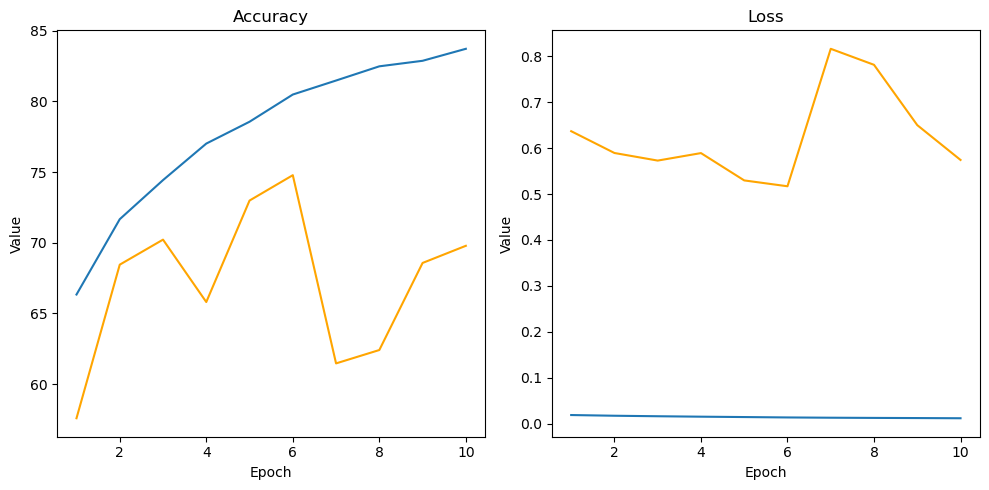

In [17]:
best_accuracy = 0.0
least_difference = sys.float_info.max
patience = 4
patience_counter = 0
training = {
    "accuracies":[],
    "losses":[]    
}
validation = {
    "accuracies":[],
    "losses":[]    
}

for epoch in range(1, NUM_EPOCHS + 1):
    training_accuracy, training_loss = train(train_loader, epoch, writer)
    val_accuracy, val_loss = validate(validation_loader, writer, epoch)

    training["accuracies"].append(training_accuracy)
    training["losses"].append(training_loss)

    validation["accuracies"].append(val_accuracy)
    validation["losses"].append(val_loss)

    if best_accuracy < val_accuracy or least_difference > abs(training_accuracy - val_accuracy):
        best_accuracy = val_accuracy
        least_difference = abs(training_accuracy - val_accuracy)
        saveModel(model, f"model_exp{EXPERIMENT}.pth", epoch)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered. Validation accuracy has not improved in the last", patience, "epochs.")
            break

Utils.plot_accuracies_and_losses(list(range(1, epoch + 1)), training, validation)

### Best State Reloading

In [18]:
model = ProgCNN().to(device)
model_params = torch.load(f"models/model_exp{EXPERIMENT}.pth")
model.load_state_dict(model_params["model_state_dict"])

<All keys matched successfully>

#### Evaluation

/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Training Set: Avg Loss: 0.3665, Accuracy: 12809/15345 (83.47%)
Validation Set: Avg Loss: 0.5168, Accuracy: 3086/4127 (74.78%)
Non Prog Accuracy 72.97%
Prog Accuracy 94.32%


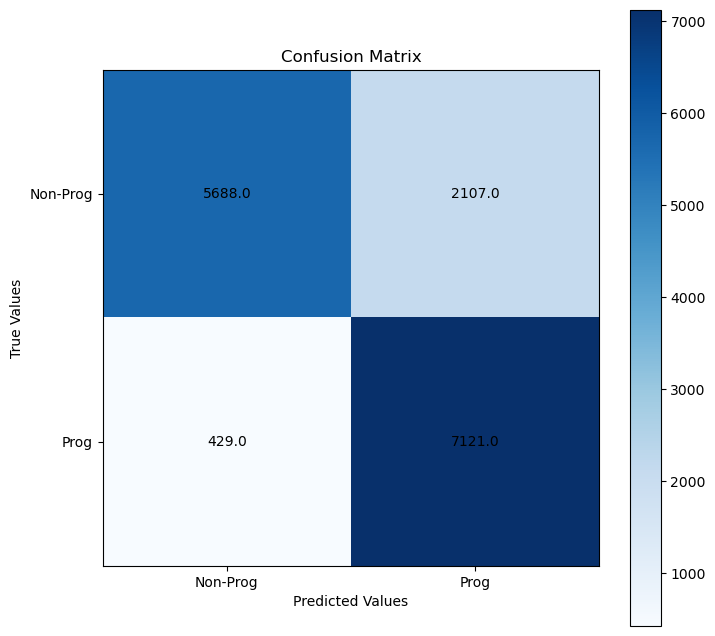

Non Prog Accuracy 65.99%
Prog Accuracy 81.06%


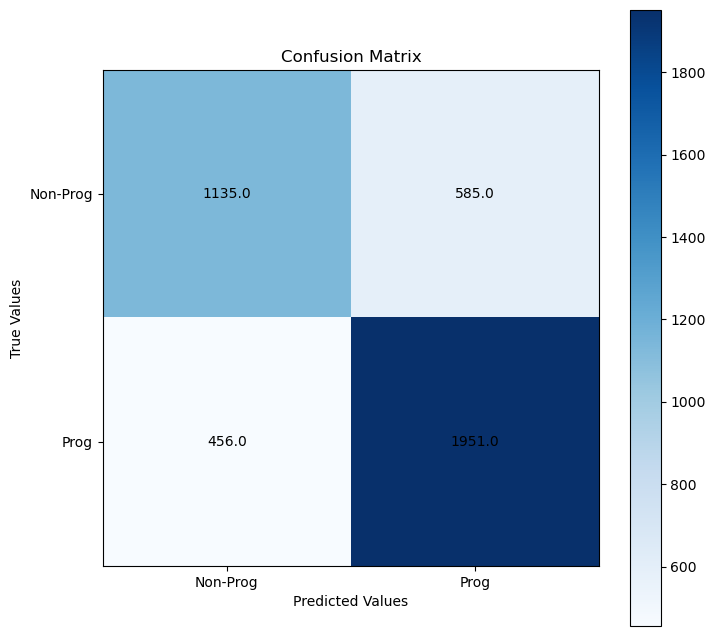

In [19]:
train_dict, train_results = evaluate(train_loader, model, set_name="Training")
validation_dict, val_results = evaluate(validation_loader, model, set_name="Validation")

Utils.getClassAccuracies(train_results, CLASS_NAMES)
Utils.plot_confusion_matrix(train_results["conf_matrix"], CLASS_NAMES)
Utils.getClassAccuracies(val_results, CLASS_NAMES)
Utils.plot_confusion_matrix(val_results["conf_matrix"], CLASS_NAMES)

### Voting
#### Voting on Training

1)	06 The Temple of the King.mp3	 1:0	0.53
2)	04 - A Lovely Night.mp3	 1:0	0.7
3)	Chinna Chinna Aasai - ROJA.mp3	 1:0	0.53
4)	06-alone_again_or_320_lame_cbr.mp3	 1:0	0.52
5)	1971_Rod_Stewart_Maggie_May.mp3	 1:0	0.69
6)	06 - Sigur Rós - Sæglópur.mp3	 1:0	0.75
7)	07-Cage-The-Elephant---Aint-No-Rest-For-The-Wicked.mp3	 1:0	0.52
8)	04-The Rip.mp3	 1:0	0.63
9)	1961_Lawrence_Welk_Calcutta.mp3	 1:0	0.58
10)	06 Naima.mp3	 1:0	0.54
11)	11 Better Man.mp3	 1:0	0.67
12)	04. Air Supply - All Out Of Love.mp3	 1:0	0.66
13)	1965_Beach_Boys_California_Girls.mp3	 1:0	0.56
14)	08 - Asmarina (My Asmara).mp3	 1:0	0.63
15)	04 - Ayasofya.mp3	 1:0	0.54
16)	2000_Sting_Desert_Rose.mp3	 1:0	0.67
17)	03-House Of The Rising Sun.mp3	 1:0	0.66
18)	03 - No Doubt - Just a Girl.mp3	 1:0	0.68
19)	02 Aja.mp3	 1:0	0.6
20)	02 - Adagio in C Minor.mp3	 1:0	0.57
21)	03. Ten-Day Interval.mp3	 1:0	0.51
22)	1972_Don_McLean_American_Pie.mp3	 1:0	0.62
23)	12_Toxicity.mp3	 1:0	0.66
24)	Gin_Blossoms_Hey_Jealousy.mp3	 1:0	0.57
25)	19

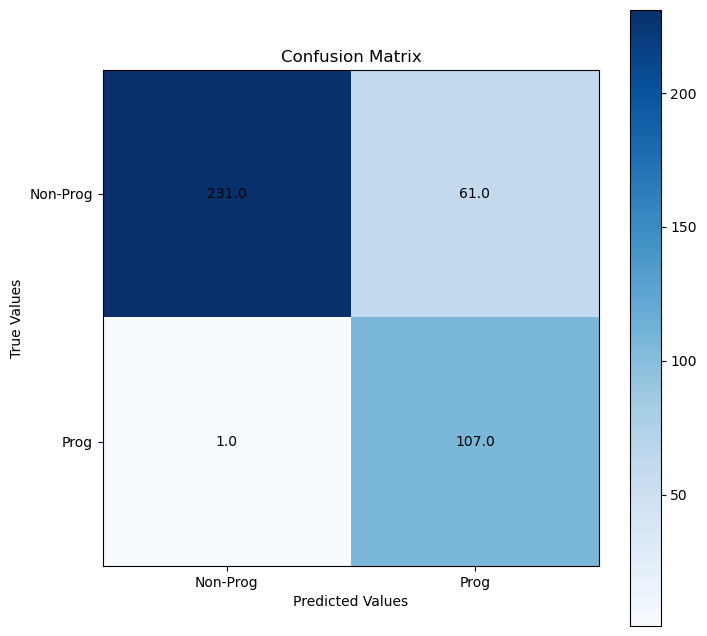

In [20]:
train_songs_probabilities, train_labels = rec.prepareSongData(train_dict, train_songs)
correct = 0
mis_classified_count = 0
predictions = []
songs_table = []
with torch.no_grad():
    for idx, (name, song, label) in enumerate(zip(train_dict.keys(), train_songs_probabilities, train_labels)):
        pred = Utils.getSongPredictions([(snip > 0.5).long().item() for snip in song.view(-1)])
        correct += (pred == label.item())
        predictions.append(pred)
        if pred != label:
            mis_classified_count += 1
            print(f"{mis_classified_count})\t{name}\t {pred}:{label.item()}\t{round(torch.mean(song.view(-1)).item(), 2)}")
            songs_table.append([name, int(label.item()), pred, round(torch.mean(song.view(-1)).item(), 2)])
    accuracy = 100. * (correct / len(train_songs_probabilities))
    result = Utils.getConfusionMatrix({}, predictions, train_labels)

generate_table(f"voting_training_exp{EXPERIMENT}", songs_table)
print(f"\nAccuracy after Voting: {accuracy:.2f}%")
Utils.getClassAccuracies(result, CLASS_NAMES)
Utils.plot_confusion_matrix(result["conf_matrix"], CLASS_NAMES)

#### Voting on Validation

1)	01 - It's The End Of The World As We Know It (And I Feel Fine) (Edit) (2006 Digital Remaster).mp3	 1:0	0.51
2)	11 - Inoculate the Innocuous.mp3	 1:0	0.57
3)	02 - Someone In The Crowd.mp3	 1:0	0.61
4)	1995_Hootie_And_The_Blowfish_Hold_My_Hand.mp3	 1:0	0.56
5)	03_YYZ_Rush_Moving_Pictures_Deluxe_Edition_2011.mp3	 0:1	0.42
6)	09-Year Of The Cat.mp3	 1:0	0.57
7)	Hallelujah_Kate_McKinnon.mp3	 1:0	0.65
8)	1997_The_Verve_Bittersweet_Symphony.mp3	 1:0	0.65
9)	02 Peace Of Mind.mp3	 1:0	0.66
10)	1986_Mr._Mister_Broken_Wings.mp3	 1:0	0.5
11)	02 - Zombified.mp3	 1:0	0.76
12)	Green Day -07- Basket Case.mp3	 1:0	0.87
13)	1956_Elvis_Presley_Heartbreak_Hotel.mp3	 1:0	0.61
14)	03 - Halleluwah.mp3	 0:1	0.29
15)	13 - So Long, Farewell.mp3	 1:0	0.49
16)	20 - They Can't Take That Away from Me (Remastered).mp3	 1:0	0.73
17)	14 - 25 or 6 to 4 (Steven Wilson Remix).mp3	 1:0	0.75
18)	Collective Soul_The World I Know.mp3	 1:0	0.73
19)	02 - A Whiter Shade Of Pale.mp3	 1:0	0.56
20)	01_Pulcinella_1st_scene_Overt

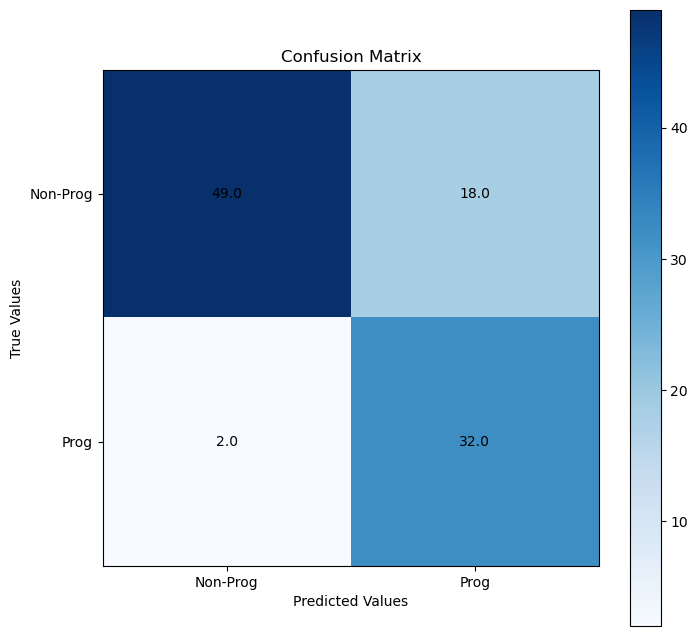

In [21]:
validate_songs_probabilities, validate_labels = rec.prepareSongData(validation_dict, validate_songs)
correct = 0
mis_classified_count = 0
predictions = []
songs_table = []
with torch.no_grad():
    for idx, (name, song, label) in enumerate(zip(validation_dict.keys(), validate_songs_probabilities, validate_labels)):
        pred = Utils.getSongPredictions([(snip > 0.5).long().item() for snip in song.view(-1)])
        correct += (pred == label.item())
        predictions.append(pred)
        if pred != label:
            mis_classified_count += 1
            print(f"{mis_classified_count})\t{name}\t {pred}:{label.item()}\t{round(torch.mean(song.view(-1)).item(), 2)}")
            songs_table.append([name, int(label.item()), pred, round(torch.mean(song.view(-1)).item(), 2)])
    accuracy = 100. * (correct / len(validate_songs_probabilities))
    result = Utils.getConfusionMatrix({}, predictions, validate_labels)
generate_table(f"voting_validation_exp{EXPERIMENT}", songs_table)
print(f"\nAccuracy after Voting: {accuracy:.2f}%")
Utils.getClassAccuracies(result, CLASS_NAMES)
Utils.plot_confusion_matrix(result["conf_matrix"], CLASS_NAMES)

### LSTM Model

In [22]:
NUM_EPOCHS = 10
HIDDEN_SIZE = 5
NUM_LAYERS = 1
NUM_CLASSES = 1
lstm = rec.MyLSTM(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, num_classes=NUM_CLASSES).to(device)
criterion = nn.BCELoss()
LEARNING_RATE = 0.01
adam = torch.optim.Adam(lstm.parameters(), lr=LEARNING_RATE)
model_name = 'lstm'

Epoch 1: Epochwise Loss: 0.4640	Epochwise Accuracy: 311/400 77.75%
Epoch 1: Validation Loss: 0.8965	Validation Accuracy: 74/101 73.27%
Model Saved at 1th epoch as lstm_exp5.pth
Epoch 2: Epochwise Loss: 0.4566	Epochwise Accuracy: 338/400 84.50%
Epoch 2: Validation Loss: 0.8296	Validation Accuracy: 70/101 69.31%
Epoch 3: Epochwise Loss: 0.4454	Epochwise Accuracy: 323/400 80.75%
Epoch 3: Validation Loss: 1.0736	Validation Accuracy: 67/101 66.34%
Epoch 4: Epochwise Loss: 0.4526	Epochwise Accuracy: 308/400 77.00%
Epoch 4: Validation Loss: 1.0013	Validation Accuracy: 69/101 68.32%
Epoch 5: Epochwise Loss: 0.2559	Epochwise Accuracy: 362/400 90.50%
Epoch 5: Validation Loss: 0.7958	Validation Accuracy: 78/101 77.23%
Model Saved at 5th epoch as lstm_exp5.pth
Epoch 6: Epochwise Loss: 0.1535	Epochwise Accuracy: 377/400 94.25%
Epoch 6: Validation Loss: 0.8115	Validation Accuracy: 80/101 79.21%
Model Saved at 6th epoch as lstm_exp5.pth
Epoch 7: Epochwise Loss: 0.1486	Epochwise Accuracy: 377/400 94.2

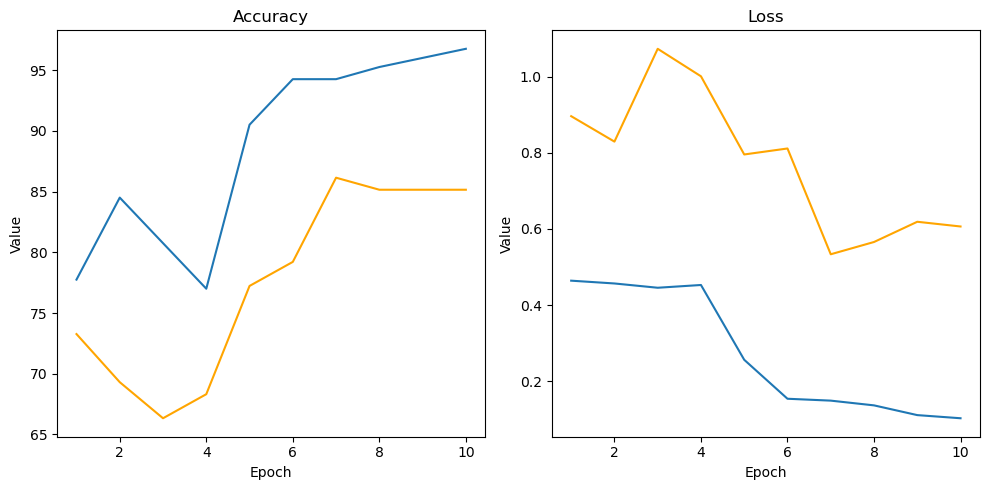

In [23]:
best_accuracy = 0.0
least_difference = sys.float_info.max
patience = 4
patience_counter = 0
training = {
    "accuracies":[],
    "losses":[]    
}
validation = {
    "accuracies":[],
    "losses":[]    
}
train_songs_probabilities, train_labels = rec.prepareSongData(train_dict, train_songs, model=model_name)
validate_songs_probabilities, validate_labels = rec.prepareSongData(validation_dict, validate_songs, model=model_name)

for epoch in range(1, NUM_EPOCHS + 1):
    train_accuracy, train_loss = rec.train_lstm(epoch, train_songs_probabilities, train_labels, lstm, criterion, adam, device)
    val_accuracy, val_loss = rec.validate_lstm(epoch, validate_songs_probabilities, validate_labels, lstm, criterion, device)

    training["accuracies"].append(train_accuracy)
    training["losses"].append(train_loss)
    validation["accuracies"].append(val_accuracy)
    validation["losses"].append(val_loss)
    
    if best_accuracy < val_accuracy or least_difference > abs(training_accuracy - val_accuracy):
        best_accuracy = val_accuracy
        least_difference = abs(training_accuracy - val_accuracy)
        saveModel(lstm, f"{model_name}_exp{EXPERIMENT}.pth", epoch)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered. Validation accuracy has not improved in the last", patience, "epochs.")
            break

Utils.plot_accuracies_and_losses(list(range(1, epoch + 1)), training, validation)


1)	Frances the Mute-The Mars Volta-05-Cassandra Geminni 1.mp3	 0:1	0.24
2)	06 Mekanik Kommandoh.mp3	 0:1	0.04
3)	08. Guardian.mp3	 0:1	0.03
4)	01 - When the Heart Rules the Mind.mp3	 0:1	0.07
5)	03_Time.mp3	 0:1	0.0
6)	01-The runaway.mp3	 0:1	0.01
7)	01_Genesis_Watcher of the Skies.mp3	 0:1	0.16
8)	Emerson_Lake_Palmer_Peter_Gunn.mp3	 0:1	0.06
9)	-04- Knots.mp3	 0:1	0.23
10)	04 Operation- Mindcrime.mp3	 0:1	0.02
11)	01 - Songs From The Wood (2003 Digital Remaster).mp3	 0:1	0.31
12)	13 - A Day in the Life.mp3	 0:1	0.19
Evaluation: Loss: 0.1094	Accuracy: 388/400 97.00%
1)	05 Soup.mp3	 0:1	0.02
2)	4-Song Of Scheherazade.mp3	 0:1	0.0
3)	Caravan_The_Love_In_Your_Eye.mp3	 0:1	0.06
4)	06 - Echoes.mp3	 0:1	0.02
5)	03_YYZ_Rush_Moving_Pictures_Deluxe_Edition_2011.mp3	 0:1	0.0
6)	01-Zarathustra.mp3	 0:1	0.0
7)	Pain of Salvation - The Perfect Element I - 02. In the Flesh.mp3	 0:1	0.0
8)	11 Bohemian Rhapsody.mp3	 0:1	0.03
9)	02. The Road Of Bones.mp3	 0:1	0.11
10)	03 A Plague of Lighthouse Keepers.m

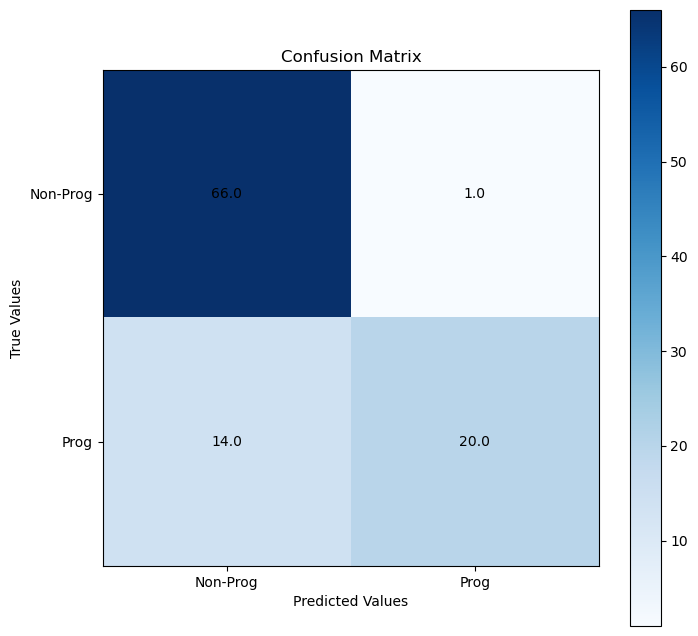

In [24]:
train_accuracy, train_loss, results, table = rec.evaluate_lstm(list(train_dict.keys()), train_songs_probabilities, train_labels, lstm, criterion, device)
generate_table(f"lstm_training_exp{EXPERIMENT}", table)
val_accuracy, val_loss, results, table = rec.evaluate_lstm(list(validation_dict.keys()), validate_songs_probabilities, validate_labels, lstm, criterion, device)
generate_table(f"lstm_validation_exp{EXPERIMENT}", table)
Utils.getClassAccuracies(result, CLASS_NAMES)
Utils.plot_confusion_matrix(results['conf_matrix'], CLASS_NAMES)

### RNN Model

In [25]:
NUM_EPOCHS = 10
HIDDEN_SIZE = 3
NUM_CLASSES = 1
rnn = rec.PredictionsRNN(input_size=1, hidden_size=HIDDEN_SIZE, output_size=NUM_CLASSES).to(device)
criterion = nn.BCELoss()
LEARNING_RATE = 0.01
adam = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)
model_name = 'rnn'

Epoch 1: Epochwise Loss: 0.3415	Epochwise Accuracy: 327/400 81.75%
Epoch 1: Validation Loss: 21.2782	Validation Accuracy: 74/101 73.27%
Model Saved at 1th epoch as rnn_exp5.pth
Epoch 2: Epochwise Loss: 2.2904	Epochwise Accuracy: 356/400 89.00%
Epoch 2: Validation Loss: 0.4177	Validation Accuracy: 78/101 77.23%
Model Saved at 2th epoch as rnn_exp5.pth
Epoch 3: Epochwise Loss: 0.1281	Epochwise Accuracy: 382/400 95.50%
Epoch 3: Validation Loss: 1.3422	Validation Accuracy: 84/101 83.17%
Model Saved at 3th epoch as rnn_exp5.pth
Epoch 4: Epochwise Loss: 0.1399	Epochwise Accuracy: 379/400 94.75%
Epoch 4: Validation Loss: 1.5030	Validation Accuracy: 84/101 83.17%
Epoch 5: Epochwise Loss: 0.1383	Epochwise Accuracy: 379/400 94.75%
Epoch 5: Validation Loss: 1.4704	Validation Accuracy: 84/101 83.17%
Epoch 6: Epochwise Loss: 0.1404	Epochwise Accuracy: 379/400 94.75%
Epoch 6: Validation Loss: 1.2301	Validation Accuracy: 84/101 83.17%
Epoch 7: Epochwise Loss: 0.1474	Epochwise Accuracy: 378/400 94.50%

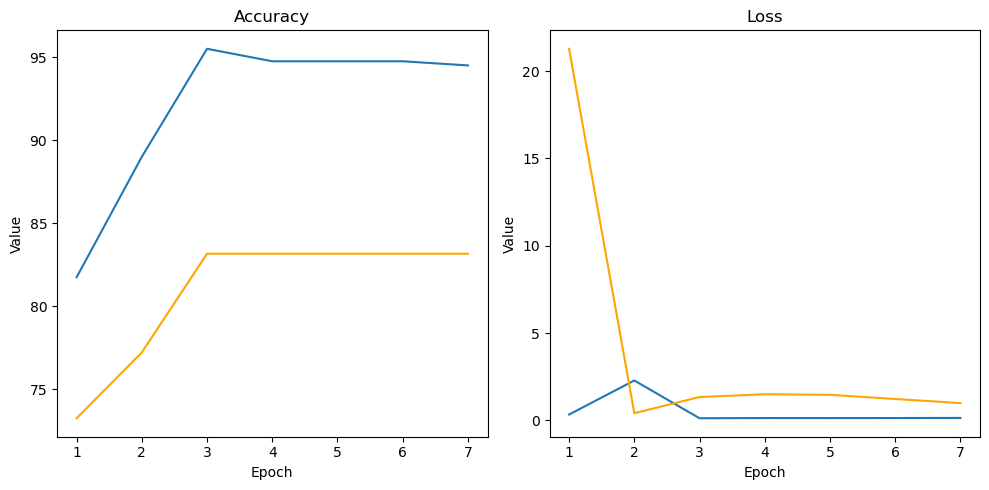

In [26]:
best_accuracy = 0.0
least_difference = sys.float_info.max
patience = 4
patience_counter = 0
training = {
    "accuracies":[],
    "losses":[]    
}
validation = {
    "accuracies":[],
    "losses":[]    
}
train_songs_probabilities, train_labels = rec.prepareSongData(train_dict, train_songs, model=model_name)
validate_songs_probabilities, validate_labels = rec.prepareSongData(validation_dict, validate_songs, model=model_name)

for epoch in range(1, NUM_EPOCHS + 1):
    train_accuracy, train_loss = rec.train_rnn(epoch, train_songs_probabilities, train_labels, rnn, criterion, adam, device)
    val_accuracy, val_loss = rec.validate_rnn(epoch, validate_songs_probabilities, validate_labels, rnn, criterion, device)

    training["accuracies"].append(train_accuracy)
    training["losses"].append(train_loss)
    validation["accuracies"].append(val_accuracy)
    validation["losses"].append(val_loss)  

    if best_accuracy < val_accuracy or least_difference > abs(training_accuracy - val_accuracy):
        best_accuracy = val_accuracy
        least_difference = abs(training_accuracy - val_accuracy)
        saveModel(rnn, f"{model_name}_exp{EXPERIMENT}.pth", epoch)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered. Validation accuracy has not improved in the last", patience, "epochs.")
            break 

Utils.plot_accuracies_and_losses(list(range(1, epoch + 1)), training, validation)


1)	Frances the Mute-The Mars Volta-05-Cassandra Geminni 1.mp3	 0:1	0.4
2)	06 Mekanik Kommandoh.mp3	 0:1	0.08
3)	08. Guardian.mp3	 0:1	0.0
4)	01 - When the Heart Rules the Mind.mp3	 0:1	0.04
5)	02. Bleed (live).mp3	 0:1	0.49
6)	03_Time.mp3	 0:1	0.0
7)	06_Genesis_Supper's Ready.mp3	 0:1	0.0
8)	01-The runaway.mp3	 0:1	0.0
9)	01_Genesis_Watcher of the Skies.mp3	 0:1	0.23
10)	02 Can You Understand.mp3	 0:1	0.24
11)	01_Shine On You Crazy Diamond I.mp3	 0:1	0.41
12)	04_La_Villa_Strangiato_Rush_Hemispheres_Deluxe_Edition.mp3	 0:1	0.29
13)	Emerson_Lake_Palmer_Peter_Gunn.mp3	 0:1	0.12
14)	-04- Knots.mp3	 0:1	0.24
15)	Procol_Harum_In_Held.mp3	 0:1	0.26
16)	04 Operation- Mindcrime.mp3	 0:1	0.0
17)	Baris_Manco_Bay_Koca_Destani_2023.mp3	 0:1	0.27
18)	06-king_crimson-larks_tounges_in_aspic_(part_ii).mp3	 0:1	0.13
19)	13 - A Day in the Life.mp3	 0:1	0.23
Evaluation: Loss: 0.1807	Accuracy: 381/400 95.25%
1)	05 Soup.mp3	 0:1	0.0
2)	4-Song Of Scheherazade.mp3	 0:1	0.0
3)	01_A_Change_of_Seasons_I_Sunrise_

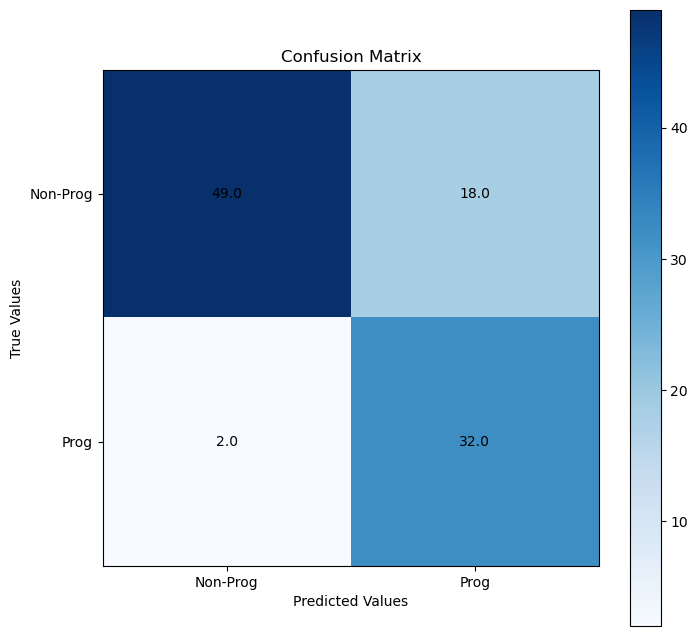

In [27]:
train_accuracy, train_loss, _, table = rec.evaluate_rnn(list(train_dict.keys()), train_songs_probabilities, train_labels, rnn, criterion, device)
generate_table(f"rnn_training_exp{EXPERIMENT}", table)
val_accuracy, val_loss, results, table = rec.evaluate_rnn(list(validation_dict.keys()), validate_songs_probabilities, validate_labels, rnn, criterion, device)
generate_table(f"rnn_validation_exp{EXPERIMENT}", table)
Utils.getClassAccuracies(result, CLASS_NAMES)
Utils.plot_confusion_matrix(result["conf_matrix"], CLASS_NAMES)